## [Rule-based Matcher Explorer](https://explosion.ai/demos/matcher)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from os import path, makedirs, listdir
from tqdm import tqdm_notebook as tqdm
from lxml import etree
import standoffconverter
from sklearn.model_selection import train_test_split

import bodleian_downloader

import pandas as pd
import numpy as np

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [7]:
from IPython.display import IFrame
IFrame('https://explosion.ai/demos/matcher', width=1000, height=1600)

In [6]:
#https://spacy.io/usage/rule-based-matching#matcher
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

# Add match ID "HelloWorld" with no callback and one pattern
pattern = [{"LOWER": "hello"}, {"IS_PUNCT": True}, {"LOWER": "world"}]
matcher.add("HelloWorld", None, pattern)

doc = nlp(u"Hello, world! Hello world!")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

15578876784678163569 HelloWorld 0 3 Hello, world


In [9]:
#https://realpython.com/natural-language-processing-spacy-python/

from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)
conference_org_text = ('There is a developer conference'
    'happening on 21 July 2019 in London. It is titled'
    ' "Applications of Natural Language Processing".'
    ' There is a helpline number available'
    ' at (123) 456-789')

def extract_phone_number(nlp_doc):
    pattern = [{'ORTH': '('}, {'SHAPE': 'ddd'},
               {'ORTH': ')'}, {'SHAPE': 'ddd'},
               {'ORTH': '-', 'OP': '?'},
               {'SHAPE': 'ddd'}]
    matcher.add('PHONE_NUMBER', None, pattern)
    matches = matcher(nlp_doc)
    for match_id, start, end in matches:
        span = nlp_doc[start:end]
        return span.text

conference_org_doc = nlp(conference_org_text)
extract_phone_number(conference_org_doc)

'(123) 456-789'

# Phrase Matcher for stage directions

First, download Shakespeare plays that have annotations for stage directions.

In [2]:
standoffs = []

for fn in tqdm(bodleian_downloader.get_file_descriptors(), desc="download and extract xml"):

    tree = etree.fromstring(open(fn, "rb").read())

    so = standoffconverter.Standoff()
    so.from_lxml_tree(tree)

    standoffs.append(so)


## Preparing the data

In [3]:
train, test = train_test_split(standoffs, random_state=4123)

In [4]:
def extract_true_stage_directions(standoffs):
    stage_directions = []
    indices = []
    for standoff in standoffs:
        indices.append([])
        for annotation in standoff.standoffs:
            if annotation["tag"] == "{http://www.tei-c.org/ns/1.0}stage":
                stage_directions.append(standoff.plain[annotation["begin"]:annotation["end"]])
                indices[-1].append((annotation["begin"],annotation["end"]))
    return stage_directions, indices
                
train_sd,_ = extract_true_stage_directions(train)

## Creating some example matchers and validate
The validation function also shows you examples of fales matches (false negatives and false positives)

precision: 1.00, recall: 0.20, f1 0.33



 **What has been identified. although it is not a stage direction? For example:**

0 examples.


**What has not been identified? For example:**

*phrase*

> "Enter a Seruant."


*phrase_with_context*

> "      
                  Enter a Seruant.
                  
     "


*phrase*

> "Exeunt."


*phrase_with_context*

> "      
                  Exeunt.
               
        "


*phrase*

> "Enter a Lord."


*phrase_with_context*

> "      
                  Enter a Lord.
                  
     "


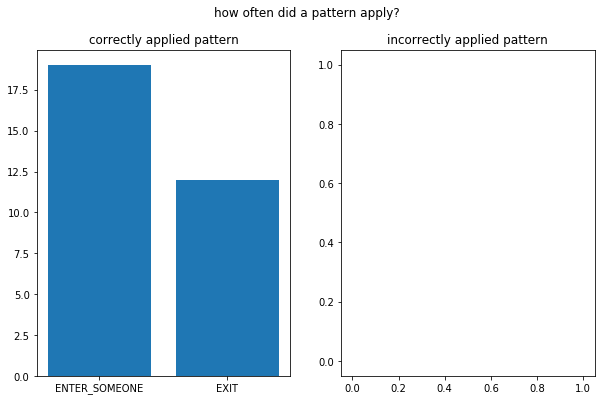

In [20]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)


pattern = [{'ORTH': 'Enter'},
           {'IS_PUNCT': True}]

matcher.add('ENTER', None, pattern)


pattern = [{'ORTH': 'Enter'},
           {'POS': 'PROPN'},
           {'IS_PUNCT': True}]

matcher.add('ENTER_SOMEONE', None, pattern)

pattern = [{'ORTH': 'Exit'},
           {'IS_PUNCT': True}]

matcher.add('EXIT', None, pattern)

pattern = [{'ORTH': 'Exit'},
           {'POS': 'PROPN'},
           {'IS_PUNCT': True}]

matcher.add('EXIT_SOMEONE', None, pattern)


def validate_stage_directions(matcher, data):

    docs = [nlp(doc.plain) for doc in data]
    
    data_sd, data_indices = extract_true_stage_directions(data)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    fn_examples = []
    fp_examples = []
    
    tp_match_names = []
    fp_match_names = []
    
    
    for idoc, doc in tqdm(enumerate(docs), total=len(docs)):
        
        ground_truth = np.zeros(len(doc.text)).astype(bool)
        prediction = np.zeros(len(doc.text)).astype(bool)
        for begin, end in data_indices[idoc]:
            ground_truth[begin:end] = True
            
        
        matches = matcher(doc)
        for match_id, begin, end in matches:
            last_ind = max(end-1, begin)
            char_begin = doc[begin].idx
            char_end = doc[last_ind].idx + len(doc[last_ind])

            prediction[char_begin:char_end] = True

                
            if ground_truth[char_begin:char_end].sum() < len(ground_truth[char_begin:char_end]):
                fp_examples.append({
                    "phrase": doc.text[char_begin:char_end],
                    "phrase_with_context":doc.text[max(0, char_begin-25):min(len(doc.text),char_end+25)]
                })
                fp_match_names.append(
                    nlp.vocab.strings[match_id]
                )
            else:
                tp_match_names.append(
                    nlp.vocab.strings[match_id]
                )

        for begin, end in data_indices[idoc]:
            if prediction[begin:end].sum() == 0:#< len(prediction[begin:end]):
                fn_examples.append({
                    "phrase": doc.text[begin:end],
                    "phrase_with_context":doc.text[max(0,begin-25):min(len(doc.text), end + 25)]
                })

        tp += np.logical_and(ground_truth, prediction).sum()
        fn += np.logical_and(ground_truth, ~prediction).sum()
        fp += np.logical_and(~ground_truth, prediction).sum()
        tn += np.logical_and(~ground_truth, ~prediction).sum()

    precision = tp /(tp + fp) if fp > 0 or tp > 0 else 0
    recall = tp /(tp + fn) if tp > 0 or fn > 0 else 0
    f1_score = 2*tp / (2*tp + fp + fn) if tp > 0 or fp > 0 or fn > 0 else 0
    print("precision: {:.2f}, recall: {:.2f}, f1 {:.2f}".format(precision, recall, f1_score))
    
    printmd("\n **What has been identified. although it is not a stage direction? For example:**")
    if len(fp_examples) > 0:
        for ex_dict in np.random.choice(fp_examples, 3):
            for k,v in ex_dict.items():
                printmd("*" + k + "*")
                print(">", "\""+v+"\"")
                
    else:
        print("0 examples.")
    printmd("**What has not been identified? For example:**")
    if len(fn_examples) > 0:
        for ex_dict in np.random.choice(fn_examples, 3):
            for k,v in ex_dict.items():
                printmd("*" + k + "*")
                print(">", "\""+v+"\"")
    else:
        print("0 examples.")

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    fig.suptitle('how often did a pattern apply?')
    
    keys, counts = np.unique(tp_match_names, return_counts=True)
    ax1.bar(keys,counts)
    ax1.set_title("correctly applied pattern")
    
    keys, counts = np.unique(fp_match_names, return_counts=True)
    ax2.bar(keys, counts)
    ax2.set_title("incorrectly applied pattern")
    
    
validate_stage_directions(matcher, train[:1])

